In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import timeit
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pdw
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox
from os import getenv, path
from pathlib import Path
from sys import getsizeof
import sys
import timeit
import seaborn as sns

In [2]:
# dynamically deciding login info 
# then login to wrds
def pgpass_dir():
    if sys.platform.startswith('win'):
        os_path = getenv('LOCALAPPDATA')
        file_path = os_path+'\postgresql\pgpass.conf'
        print (file_path)
    elif sys.platform.startswith('darwin'):
        #* can be replaced by your laptop's name
        #in order to boost searching performance
        if path.exists('/Users/*/.pgpass'):
            file_path = '/Users/*/.pgpass'
        else:
            dir_path = os.path.dirname('/Users/')
            keyword = '.pgpass'
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    if keyword in file:
                        file_path = root+'/'+str(file)
    return file_path

In [3]:
file_path = pgpass_dir()
#read login info and pass connection parameters
with open(file_path,'r') as f:
    output = f.read()
    
    login_id = output.split(":")[3]
    crsp_db = wrds.Connection(wrds_username=login_id)

Loading library list...
Done


In [4]:
#combine login into one function
#in order to keep timeout away
#issue : too many connections to server 
# not in use
def re_conn_wrds():
    file_path = pgpass_dir()
    #read login info and pass connection parameters
    with open(file_path,'r') as f:
        output = f.read()
        login_id = output.split(":")[3]
        crsp_db = wrds.Connection(wrds_username=login_id)

In [5]:
#retrieved cooresponding permno 
#criterion : the latest valid date
def data_generator(num=3, ticker_name=tuple(['GLD','SPY','TLT'])):
    ticker_list = {'tickers': tuple(ticker_name)}
    permno_list_init = crsp_db.raw_sql('SELECT a.permno FROM crsp.stocknames a, (SELECT distinct(max(nameenddt)) as date_time FROM crsp.stocknames WHERE ticker in %(tickers)s group by ticker) as b WHERE a.ticker in %(tickers)s and a.nameenddt = b.date_time group by a.permno', params=ticker_list)
    #generate tuple for permno
    permno_list_tuple = tuple(permno_list_init.permno.astype(str).values.tolist())
    permno_list = {'permno': permno_list_tuple}
    #generate data
    final_data = crsp_db.raw_sql('select distinct b.ticker, a.date, a.prc, a.ret from crspm.dsf a, crsp.stocknames b, \
    (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c \
where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc', params=permno_list,date_cols=['date'])
    return final_data

In [6]:
#generate vix data from cboe database
#vix data is from database : cboe and table : cboe
def vix_generator(self):
    vix_index = crsp_db.raw_sql('SELECT date,vix FROM cboe.cboe where vix is not NULL')
    return vix_index

In [7]:
#generate dataframe and pickle file
def input_ticker():
    number_stock = int(input("Please enter your number of stocks, e.g 3,4,5: ").strip())
    ticker_name = []
    init_weight = []
    total_weight = 1
    temp_weight = 0
    [ticker_name.append(input("Please enter one ticker each time, e.g spy, tlt, gld: ").strip().upper()) for i in range(number_stock)]
    for i in ticker_name:
        temp_i = float(input("Please enter weight for {0}. The number should be less than or equal to 10".format(i)))/10
        while temp_i > total_weight:
            temp_i = float(input("The percentage of {0} is greater than 100%, Please re-enter weight for {0}".format(i)))/10
        init_weight.append(temp_i)
        while sum(init_weight) > total_weight:
            init_weight.remove(temp_i)
            temp_i = float(input("Please re-enter weight for {0}, because of total amount is greather than 100%".format(i)))/10
            init_weight.append(temp_i)
    p_weight = dict(zip(ticker_name, init_weight))
    final_data = data_generator(number_stock,ticker_name)
    final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
    final_data_pivot = final_data_pivot.fillna(1)
    final_data_pivot.to_pickle('dummy_data.pkl')
    #generate vix data
    vix_data = vix_generator(vix_generator)
    vix_data.to_pickle('vix_data.pkl')
    return final_data_pivot, p_weight, vix_data

In [8]:
#new function for loading bulky tickers
def bulky_import(path_location):
    ticker_name = []
    init_weight = []
    total_weight = 1
    if path.exists(path_location):
        with open(path_location) as temp_file:
            for line in temp_file:
                ticker_1, number_1 = line.rstrip().split(',')
                ticker_name.append(ticker_1.upper())
                init_weight.append(number_1)
            weight = list(map(float,init_weight))
        if (sum(weight))/10 > total_weight:
            return (print ("The total percentage is greather than 100%, please check import file")),''
        else:
            p_weight = dict(zip(ticker_name,weight))
            final_data = data_generator(len(ticker_name), ticker_name)
            final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
            final_data_pivot = final_data_pivot.fillna(1)
            final_data_pivot.to_pickle('dummy_data.pkl')
            #generate vix data
            vix_data = vix_generator(vix_generator)
            vix_data.to_pickle('vix_data.pkl')
            return final_data_pivot, p_weight, vix_data
    else:
        return (print("File do not exist!")),''

In [9]:
#bulky load from local file
#can be escaped when test
final_data_pivot, p_weight , vix_data= bulky_import(r'/Volumes/backup/MSCA31001 Reserch Desgin/Capstone_TDAmeritrade/all_tickers.txt')

In [10]:
final_data_pivot

ticker            AAPL                   GLD                 PINS            \
                   prc       ret         prc       ret        prc       ret   
date                                                                          
2019-04-18  203.860001  0.003594  120.370003  0.000748  24.400000  1.000000   
2019-04-22  204.529999  0.003287  120.370003  0.000000  24.990000  0.024180   
2019-04-23  207.479996  0.014423  120.120003 -0.002077  25.850000  0.034414   
2019-04-24  207.160004 -0.001542  120.470001  0.002914  26.799999  0.036750   
2019-04-25  205.279999 -0.009075  120.570000  0.000830  28.799999  0.074627   
...                ...       ...         ...       ...        ...       ...   
2021-01-25  142.919998  0.027684  174.050003  0.000863  73.370003  0.003968   
2021-01-26  143.160004  0.001679  173.619995 -0.002471  69.239998 -0.056290   
2021-01-27  142.059998 -0.007684  172.520004 -0.006336  64.669998 -0.066002   
2021-01-28  137.089996 -0.034985  172.679993  0.000927  68.510002  0.059378   
2021-01-29  131.960007 -0.037421  172.610001 -0.000405  68.510002  0.000000   

ticker             SPY                   TLT                  TSLA            
                   prc       ret         prc       ret         prc       ret  
date                                                                          
2019-04-18  290.019989  0.001969  122.900002  0.005235  273.260010  0.007484  
2019-04-22  290.269989  0.000862  122.309998 -0.004801  262.750000 -0.038462  
2019-04-23  292.880005  0.008992  122.570000  0.002126  263.899994  0.004377  
2019-04-24  292.230011 -0.002219  123.570000  0.008159  258.660004 -0.019856  
2019-04-25  292.049988 -0.000616  123.389999 -0.001457  247.630005 -0.042643  
...                ...       ...         ...       ...         ...       ...  
2021-01-25  384.390015  0.003944  153.669998  0.011786  880.799988  0.040348  
2021-01-26  383.790009 -0.001561  153.380005 -0.001887  883.090027  0.002600  
2021-01-27  374.410004 -0.024440  153.770004  0.002543  864.159973 -0.021436  
2021-01-28  377.630005  0.008600  152.919998 -0.005528  835.429993 -0.033246  
2021-01-29  370.070007 -0.020020  152.000000 -0.006016  793.530029 -0.050154  

[450 rows x 12 columns]

In [11]:
p_weight

{'SPY': 1.0, 'TLT': 2.0, 'GLD': 3.0, 'TSLA': 1.0, 'PINS': 2.0, 'AAPL': 1.0}

In [13]:
final_data_pivot, p_weight, vix_data = input_ticker()

In [14]:
final_data_pivot

ticker             GLD                   SPY                   TLT          
                   prc       ret         prc       ret         prc       ret
date                                                                        
2004-11-18   44.380001  1.000000  118.739998  0.001349   88.970001  0.003044
2004-11-19   44.779999  0.009013  117.419998 -0.011117   88.260002 -0.007980
2004-11-22   44.950001  0.003796  117.980003  0.004769   88.720001  0.005212
2004-11-23   44.750000 -0.004449  118.160004  0.001526   88.830002  0.001240
2004-11-24   45.049999  0.006704  118.440002  0.002370   88.830002  0.000000
...                ...       ...         ...       ...         ...       ...
2021-01-25  174.050003  0.000863  384.390015  0.003944  153.669998  0.011786
2021-01-26  173.619995 -0.002471  383.790009 -0.001561  153.380005 -0.001887
2021-01-27  172.520004 -0.006336  374.410004 -0.024440  153.770004  0.002543
2021-01-28  172.679993  0.000927  377.630005  0.008600  152.919998 -0.005528
2021-01-29  172.610001 -0.000405  370.070007 -0.020020  152.000000 -0.006016

[4077 rows x 6 columns]

In [15]:
with open('vix_data.pkl', 'rb') as f: dummy_data = pickle.load(f)
vix = dummy_data.iloc[-4035:]
vix

,date,vix
3752,2004-11-19,13.50
3753,2004-11-22,12.97
3754,2004-11-23,12.67
3755,2004-11-24,12.72
3756,2004-11-26,12.78
...,...,...
7782,2020-11-23,22.66
7783,2020-11-24,21.64
7784,2020-11-25,21.25
7785,2020-11-27,20.84


In [3]:
with open('low_var_port.pkl', 'rb') as f: data = pickle.load(f)
data = data.iloc[:,[1,5,9]]
data.iloc[0] = [1,1,1]
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
initial_money = 1000000
rebalance_days = 4500
threshold = .05

In [4]:
#Simulating the daily returns for each of the assets within the portfolio
def sim_returns(data, random_seed=None,block_size = 20, total_sim = 10):
    ret_index = [x for x, y in enumerate(data.columns) if y[1] == 'ret']
    ret_sim = data.iloc[:,ret_index].to_numpy()
    rs = np.random.RandomState(random_seed)
    ret_sim_mod = CircularBlockBootstrap(block_size, ret_sim, random_state = rs)
    col = ret_sim.shape[1]
    sim = np.zeros((total_sim,len(data), col))
    count = 0
    for y in ret_sim_mod.bootstrap(total_sim):
        sim[count,:,:] = y[0][0]
        count +=1
    return sim

In [7]:
sim_returns(data, random_seed=3,block_size = 20, total_sim = 10)

array([[[1.00757222, 0.98662334, 0.99885578],
        [1.02246838, 0.98001571, 1.00044551],
        [1.00060621, 1.00151935, 0.98276187],
        ...,
        [1.00228967, 1.01243724, 0.99636296],
        [1.01219984, 0.99504049, 0.98861466],
        [0.99126047, 1.00214707, 0.99920882]],

       [[1.00233613, 1.00386342, 1.00367975],
        [1.00004093, 0.99937165, 1.01588728],
        [1.00114486, 1.00322229, 0.9978346 ],
        ...,
        [1.01593934, 1.00888206, 0.99873315],
        [1.01161226, 1.00033862, 1.00245757],
        [0.98751349, 0.99856141, 0.98956109]],

       [[1.00554682, 0.99746886, 1.01105192],
        [0.9996214 , 1.00892854, 1.00170557],
        [1.00005415, 1.00530973, 0.99148668],
        ...,
        [1.02013188, 0.99399316, 1.01969484],
        [0.9999138 , 1.01256592, 1.00625996],
        [0.99879342, 0.99166354, 0.98907517]],

       ...,

       [[1.01327518, 0.9923347 , 1.00535816],
        [1.00362396, 1.00268212, 1.01022117],
        [1.01549783, 0

In [8]:
def val_pul(ls, i):
    return ls[i]

In [9]:
def ret_rebalance(data,portfolio_weights, initial_money = 1000000, rebalance_days = 20, threshold = 10):
    
    arr_data = np.array(data)

    arr_port_det = np.zeros([data.shape[0], data.shape[1]*3]) #Need to change back to data
    arr_port_sum = np.zeros([data.shape[0], 1])
    arr_port_ret = np.zeros([data.shape[0], 1]) #Need to change back to data
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

    arr_data = np.array(data)
    cum_ret_2 = np.cumprod(arr_data, axis=0)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.zeros(data.shape[1])
    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights
    num_assets = cum_ret_2.shape[1]
    
    for row in cum_ret_2:
        tradeflag = 0
        arr_latest_ret = row
        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        
        total_value = sum(cur_asset_val)
        
        
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)
        
        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:
           
            
            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
            
            #end_time1 = timeit.default_timer()-start_time1
            #print('1 '+str(end_time1))
        else:
            trading_day_counter += 1    
        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"

        
      
        test = [[row[[i]], arr_actual_weights[i], cur_asset_val[i]] for i in range(num_assets)]
        test2 = [item for regularlist in test for item in regularlist]
        arr_port_det[count] = test2

        

        if count == 0:
            arr_port_ret[count] = 0
        else:
            arr_port_ret[count] = [(total_value/arr_port_sum[count-1])-1]
        arr_port_sum[count] = [total_value]
        tradeflag = 0
        count += 1
        
        
    return arr_port_sum, arr_port_det, arr_port_ret

In [108]:
def ret_rebalance_old(data,portfolio_weights, initial_money = 1000000, rebalance_days = 20, threshold = 10):
    
    arr_data = np.array(data)
    
    '''ls_tickers = []
    temp_tickers = list([y[0] for x, y in enumerate(arr_data_columns)])
    for i in temp_tickers:
        if i not in ls_tickers:
            ls_tickers.append(i)'''

    arr_port_det = np.zeros([data.shape[0], data.shape[1]*3]) #Need to change back to data
    arr_port_sum = np.zeros([data.shape[0], 1]) #Need to change back to data
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

    arr_data = np.array(data)
    cum_ret_2 = np.cumprod(arr_data, axis=0)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.zeros(data.shape[1])
    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights
    num_assets = cum_ret_2.shape[1]
    
    for row in cum_ret_2:
        tradeflag = 0
        arr_rebal = np.zeros(num_assets)
        arr_latest_ret = row
        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        total_value = sum(cur_asset_val)
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
        else:
            trading_day_counter += 1    
        start_time2=timeit.default_timer()
        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        #total_value

        arr_new_port_det = np.array([], dtype='f8')
        ls_new_port_det = []
        for i in range(num_assets):

            ls_new_port_det = ls_new_port_det + [row[[i]], arr_actual_weights[i], cur_asset_val[i]]
        
        arr_port_det[count] = ls_new_port_det
        end_time2 = timeit.default_timer()-start_time2
        print('2 '+str(end_time2))
        #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        arr_new_port_sum = [total_value]

        arr_port_sum[count] = [total_value]
        tradeflag = 0
        count += 1
        
    return arr_port_sum, arr_port_det

In [111]:
start_time1=timeit.default_timer()
a,b,c = ret_rebalance(data,portfolio_weights, initial_money = 1000000, rebalance_days = 1, threshold = 10)
end_time1 = timeit.default_timer()-start_time1


## Evaluation code

In [363]:
total_sim = 100
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(data), sum_col))
arr_ret_value = np.zeros((total_sim,len(data), sum_col))
arr_det_value = np.zeros((total_sim,len(data), det_col))
arr_ann_ret_nb = np.zeros((total_sim, 1))
arr_std_ret_nb = np.zeros((total_sim, 1))
counter = 0
ls_rebal_day = [1,21,63,126,253,400000]
ls_threshold = [.01,.05,.1,.2,.25,1000]
ls_performance = []
for d in ls_rebal_day:
    for t in ls_threshold:
        for x in range(total_sim):

            bootstrap = sim_returns(data,block_size = 20, total_sim = 1, random_seed = x)

            bootstrap[0][0] = [1,1,1]

            arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(bootstrap[0],portfolio_weights, initial_money = 1, rebalance_days = d, threshold = t)

            
            arr_sum_value[x] = arr_port_sum
            arr_det_value[x] = arr_port_det
            arr_ret_value[x] = arr_port_ret
    
        counter +=1
        
        for x in range(total_sim):
            arr_ann_ret_nb[x] =  arr_sum_value[x][-1]**(1/years)-1
            arr_std_ret_nb[x] = np.std(arr_ret_value[x])*(trading_days_per_year**.5)
        
        
        ls_performance.append([d,t,np.mean(arr_ann_ret_nb),np.mean(arr_std_ret_nb)])

In [365]:
df_performance = pd.DataFrame(ls_performance, columns = ['rebal_days', 'threshold', 'ann_ret', 'daily_var'])
df_performance['ann_std'] = df_performance['daily_var']**(.5)*(253**(.5))
df_performance

In [114]:
with open('df_performance.pkl', 'rb') as f: df_performance = pickle.load(f)

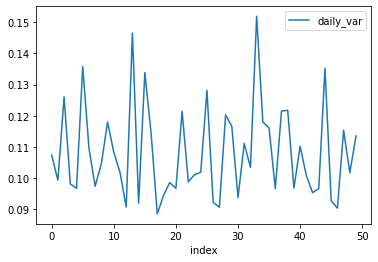

In [115]:
df = pd.DataFrame (arr_std_ret_nb,columns=['daily_var'])
df.reset_index().plot(x ='index', y='daily_var', kind = 'line')
plt.show()

In [118]:
"""# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(9,6))
# Time series plot with Seaborn lineplot()
sns.lineplot(x="date", y="positiveIncrease", 
            data=corona_ny, ci=None)
# axis labels
plt.xlabel("Date", size=14)
plt.ylabel("Daily New Cases", size=14)
# save image as PNG file
plt.savefig("Time_Series_Plot_with_Seaborn.png",
                    format='png',
                    dpi=150)"""

NameError: name 'corona_ny' is not defined

<Figure size 648x432 with 0 Axes>

In [367]:
df_performance.to_pickle('df_performance.pkl')

In [119]:

by_threshd_result = df_performance[df_performance['rebal_days']==max(ls_rebal_day)]
by_threshd_result = by_threshd_result[by_threshd_result['threshold']!=max(ls_threshold)]

del by_threshd_result['rebal_days']
by_threshd_result['threshold'] = by_threshd_result['threshold'].astype(float).map("{:.0%}".format)
by_threshd_result['ann_ret'] = by_threshd_result['ann_ret'].astype(float).map("{:.2%}".format)
by_threshd_result['daily_var'] = by_threshd_result['daily_var'].astype(float).map("{:.2%}".format)
by_threshd_result['ann_std'] = by_threshd_result['ann_std'].astype(float).map("{:.2%}".format)

In [120]:
by_timep_result = df_performance[df_performance['rebal_days']!=max(ls_rebal_day)]
by_timep_result = by_timep_result[by_timep_result['threshold']==max(ls_threshold)]

del by_timep_result['threshold']
by_timep_result['ann_ret'] = by_timep_result['ann_ret'].astype(float).map("{:.2%}".format)
by_timep_result['daily_var'] = by_timep_result['daily_var'].astype(float).map("{:.2%}".format)
by_timep_result['ann_std'] = by_timep_result['ann_std'].astype(float).map("{:.2%}".format)

In [121]:
import six
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1.5, 1.5], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,cellLoc='center', **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

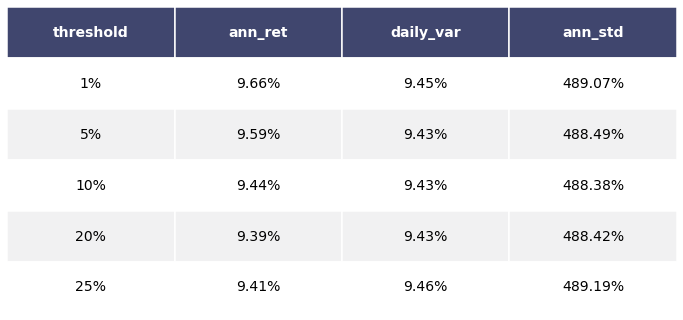

In [122]:
render_mpl_table(by_threshd_result, header_columns=0, col_width=2.0)

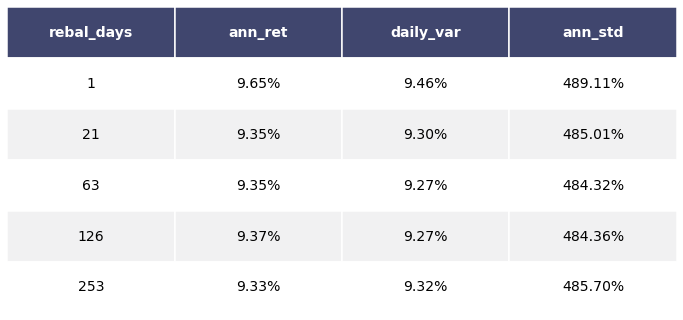

In [123]:
render_mpl_table(by_timep_result, header_columns=0, col_width=2.0)

## High Variance Cases

#### Simulating cases with vix price data added.

In [10]:
with open('vix_data.pkl', 'rb') as f: dummy_data = pickle.load(f)
vix = dummy_data.iloc[-4035:]

df_hvar = data
df_hvar[('vix','ret')] = list(vix['vix'])
df_hvar

ticker,SPY,TLT,GLD,vix
metric,ret,ret,ret,ret
date,,,,
2004-11-19,1.000000,1.000000,1.000000,13.50
2004-11-22,1.004769,1.005212,1.003796,12.97
2004-11-23,1.001526,1.001240,0.995551,12.67
2004-11-24,1.002370,1.000000,1.006704,12.72
2004-11-26,0.999156,0.993471,1.005327,12.78
...,...,...,...,...
2020-11-23,1.005994,0.995418,0.980306,22.66
2020-11-24,1.016114,0.990048,0.984672,21.64


In [12]:
bootstrap = sim_returns(df_hvar,block_size = 20, total_sim = 1000, random_seed = 5)

In [38]:
ls_avgvix = []
for x in bootstrap:
    avgvix = np.mean(x[:,3])
    ls_avgvix.append(avgvix)


In [39]:
df_avgvix = pd.DataFrame(ls_avgvix, columns = ['avg_vix'])

#### Taking simulations >75th percentile of vix price.

In [40]:
df_vix_75 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.75)[0]]

In [41]:
ls_high_var_75 = []
for x in list(df_vix_75.index):
    ls_high_var_75.append(bootstrap[x][:,0:3])


#### Taking simulations >75th percentile of vix price.

In [43]:
df_vix_95 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.95)[0]]

ls_high_var_95 = []
for x in list(df_vix_95.index):
    ls_high_var_95.append(bootstrap[x][:,0:3])


In [83]:
y = ls_high_var_95[2]
y[0]=[1,1,1]
y

array([[1.        , 1.        , 1.        ],
       [0.9954119 , 0.98702991, 0.98913206],
       [1.00581798, 1.00692761, 0.99339273],
       ...,
       [1.00754442, 1.00643749, 0.9729034 ],
       [1.0048634 , 1.00867306, 0.97832387],
       [0.98632558, 1.00397681, 1.01507157]])

In [94]:
total_sim = len(ls_high_var_95)
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(data), sum_col))
arr_ret_value = np.zeros((total_sim,len(data), sum_col))
arr_det_value = np.zeros((total_sim,len(data), det_col))
arr_ann_ret_nb = np.zeros((total_sim, 1))
arr_std_ret_nb = np.zeros((total_sim, 1))
counter = 0
ls_rebal_day = [1,21,63,126,253,400000]
ls_threshold = [.01,.05,.1,.2,.25,1000]
ls_performance_95 = []
for d in ls_rebal_day:
    for t in ls_threshold:
        for x in range(len(ls_high_var_95)):

            sim = ls_high_var_95[x]
            sim[0] = [1,1,1]

            arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(sim,portfolio_weights, initial_money = 1, rebalance_days = d, threshold = t)
            
            arr_sum_value[x] = arr_port_sum
            arr_det_value[x] = arr_port_det
            arr_ret_value[x] = arr_port_ret
    
        counter +=1
        
        for x in range(total_sim):
            arr_ann_ret_nb[x] =  arr_sum_value[x][-1]**(1/years)-1
            arr_std_ret_nb[x] = np.std(arr_ret_value[x])*(trading_days_per_year**.5)
        
        
        ls_performance_95.append([d,t,np.mean(arr_ann_ret_nb),np.mean(arr_std_ret_nb)])

In [95]:
df_performance_95 = pd.DataFrame(ls_performance_95, columns = ['rebal_days', 'threshold', 'ann_ret', 'mean_ann_std', 'std_ann_ret'])
df_performance_95['ann_std'] = df_performance_95['daily_var']**(.5)*(253**(.5))
df_performance_95

,rebal_days,threshold,ann_ret,daily_var,ann_std
0,1,0.01,0.092829,0.104112,5.132280
1,1,0.05,0.092829,0.104112,5.132280
2,1,0.10,0.092829,0.104112,5.132280
3,1,0.20,0.092829,0.104112,5.132280
4,1,0.25,0.092829,0.104112,5.132280
5,1,1000.00,0.092829,0.104112,5.132280
6,21,0.01,0.092861,0.104097,5.131904
7,21,0.05,0.092082,0.103794,5.124434
8,21,0.10,0.089823,0.103551,5.118432
9,21,0.20,0.089070,0.102360,5.088926


In [89]:
df_performance_95.to_pickle('df_performance_95.pkl')

In [49]:
ls_cumret = []

for x in bootstrap:
    port = x[:,0:3]
    port[0] = [1,1,1]
    cumret = np.cumprod(port, axis = 0)
    cumret = cumret*np.array([.5,.4,.1])
    cumret = np.sum(cumret, axis = 1)
    ls_cumret.append(cumret)

In [48]:
np.sum(cumret, axis = 1)

array([1.        , 0.99928696, 0.99734182, ..., 4.0432417 , 4.05197498,
       4.02518802])

In [29]:
x[:,0:3]

array([[1.00283857, 0.99537858, 0.98076453],
       [0.99836885, 1.00164746, 1.00049657],
       [1.01302254, 0.98856161, 0.99346567],
       ...,
       [1.00319406, 0.9830598 , 1.01173143],
       [0.98736399, 1.00413275, 0.99104356],
       [1.00964599, 0.99108864, 0.99628823]])

In [45]:
ls_cumret[]

array([[0.5       , 0.4       , 0.1       ],
       [0.5010722 , 0.39649279, 0.10172198],
       [0.49477318, 0.40079674, 0.1017719 ],
       ...,
       [0.81289248, 2.83058986, 0.39975937],
       [0.81044563, 2.84099389, 0.40053547],
       [0.80887065, 2.81687549, 0.39944189]])

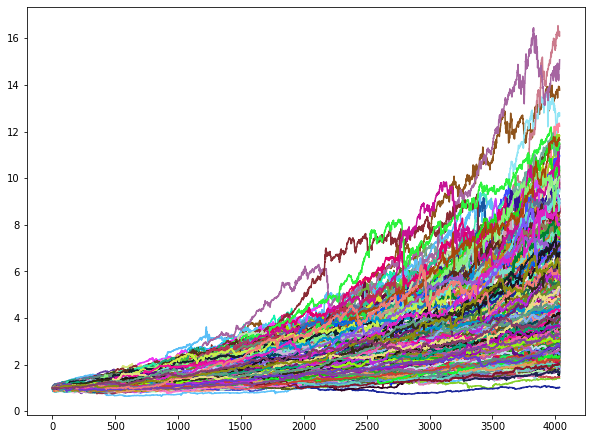

In [50]:
import random

b = list(range(4035))
a = ls_cumret #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

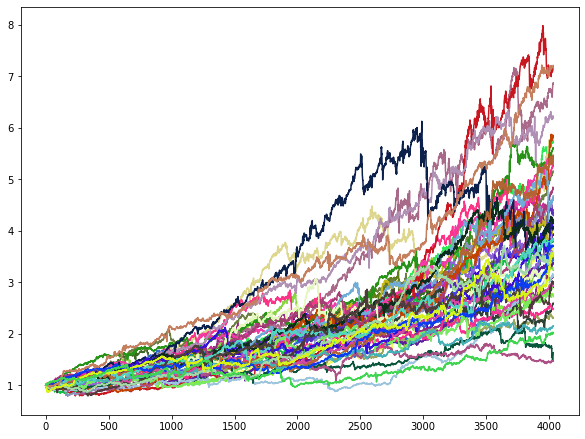

In [55]:
b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_95.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

In [57]:
df_vix_99 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.99)[0]]

ls_high_var_99 = []
for x in list(df_vix_99.index):
    ls_high_var_99.append(bootstrap[x][:,0:3])

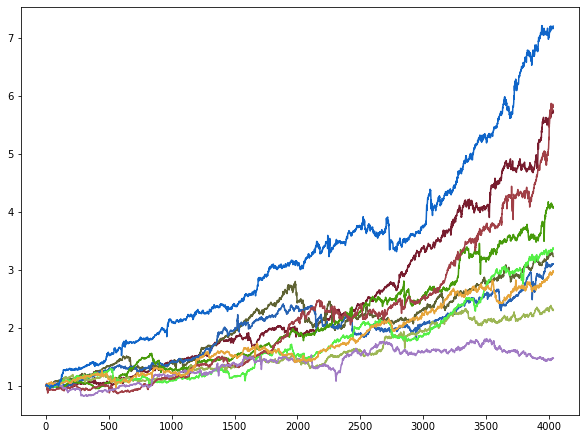

In [58]:
b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_95.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

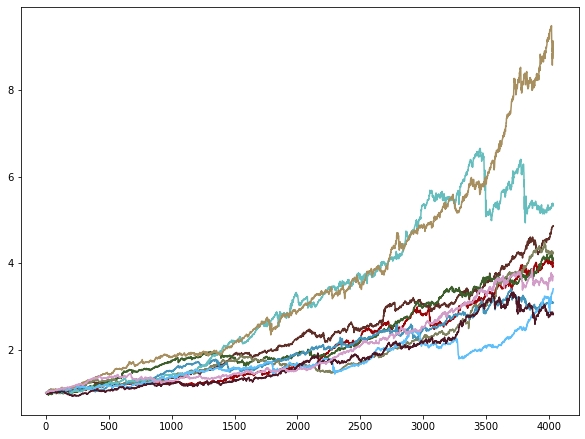

In [59]:
df_vix_01 = df_avgvix[df_avgvix['avg_vix']<df_avgvix.quantile(q=.01)[0]]


b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_01.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)